## Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import sparse
from surprise import Dataset, Reader, SVD
from collections import Counter

In [4]:
interaction = pd.read_csv("training_data/data.csv")
interaction.head()

,user_id,song_id,listen_count,timestamp,interaction
0,1,117,1,2024-02-15 17:52:02.230865,1
1,34,273,0,2024-12-27 04:50:02.231072,0
2,25,10,2,2024-04-18 21:53:02.231078,1
3,61,66,4,2024-05-30 08:08:02.231083,1
4,20,304,4,2024-08-01 20:25:02.231087,2


## Data Analysis and Preprocessing

### User Behaviour Analysis

Average number of listens per user: 44.54
Most active users: [26, 9, 86, 21, 74, 48, 24, 54, 32, 23] and Most Inactive Users: [58, 18, 92, 96, 93, 82, 2, 94, 51, 99]


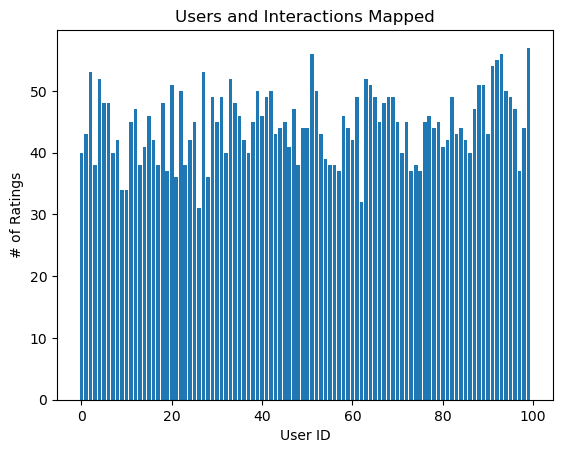

In [7]:
# users = Counter(sorted(interaction["user_id"]))
users = interaction["user_id"].value_counts()

# plot user interactions
plt.title("Users and Interactions Mapped")
plt.bar(users.index,users.values)
plt.xlabel("User ID")
plt.ylabel("# of Ratings")

# average listens per user
average_ratings_per_user = users.mean()
print("Average number of listens per user:",average_ratings_per_user)

# top 10 active/inactive users
listen_count_users = interaction.groupby("user_id")["listen_count"].sum()
sorted_users = listen_count_users.sort_values(ascending=True)
top_active_users = list(sorted_users.index[:10])
top_inactive_users = list(sorted_users.index[-10:])
print(f'Most active users: {top_active_users} and Most Inactive Users: {top_inactive_users}')


### Song Analysis

Number of unique songs: 379
Number of unlistened songs: 5
Most played songs: [92, 191, 104, 347, 331] and Least played songs: [354, 426, 379, 216, 449]


Text(0, 0.5, 'Number of Listens')

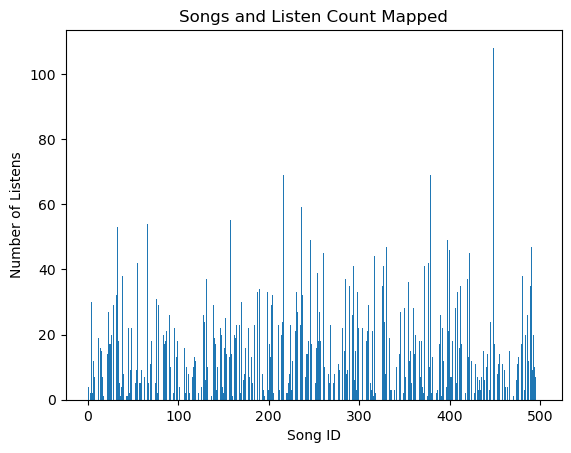

In [9]:
songs = interaction["song_id"]

# number of songs
unique_songs = songs.nunique()
print(f'Number of unique songs: {unique_songs}')

# check for unrated songs
all_songs = songs.unique()
listen_count = interaction.groupby("song_id")["listen_count"].sum()
listen_count = listen_count.reindex(all_songs, fill_value=0)
unplayed = (listen_count == 0).sum()
print(f'Number of unlistened songs: {unplayed}')

#top 5 most/least played songs
sorted_listen_count = listen_count.sort_values(ascending=True)
top_played_songs = list(sorted_listen_count.index[:5])
least_played_songs = list(sorted_listen_count.index[-5:])
print(f'Most played songs: {top_played_songs} and Least played songs: {least_played_songs}')


# plot listen counts
plt.title("Songs and Listen Count Mapped")
plt.bar(listen_count.index, listen_count.values)
plt.xlabel("Song ID")
plt.ylabel("Number of Listens")


### Rating Patterns

Text(0, 0.5, 'Frequency')

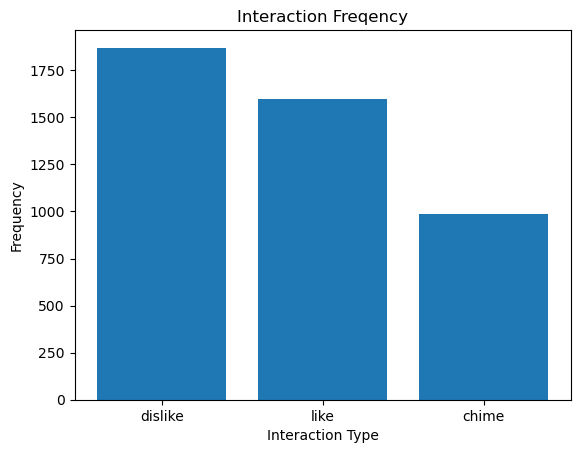

In [11]:
# ratings chart
ratings = interaction["interaction"].value_counts()
interaction_type = ["dislike","like","chime"]
plt.title("Interaction Freqency")
plt.bar(interaction_type, ratings.values)
plt.xlabel("Interaction Type")
plt.ylabel("Frequency")

### Matrix Sparsity

In [13]:
user_item_matrix = interaction.pivot(
    index='user_id',
    columns='song_id',
    values='interaction'
)

# handling empty values
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix


song_id,1,3,4,5,6,7,8,9,10,12,...,487,489,490,491,492,493,494,495,498,499
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
